## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Probability

To get started, let's import our libraries.

In [190]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

**Read in the `ab_data.csv` data. Store it in `df`.**

In [191]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**The number of rows in the dataset.**

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**The number of unique users in the dataset.**

In [193]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

**The proportion of users converted.**

In [194]:
df[df['converted'] == 1].shape[0]/df.shape[0]

0.11965919355605512

**The number of times the `new_page` and `treatment` don't match.**

In [195]:
df.query('group == "treatment" and landing_page == "old_page"').shape[0]

1965

In [196]:
df.query('group == "control" and landing_page == "new_page"').shape[0]

1928

In [197]:
df.shape[0]

294478

**Do any of the rows have missing values?**

In [198]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**For the rows where treatment does not match with new_page or control does not match with old_page, we cannot be sure if this row truly received the new or old page.**

In [199]:
df2 = df.query('(group == "treatment" and landing_page == "new_page") or (group == "control" and landing_page == "old_page")' )
print(df2.shape)
df2.head()

(290585, 5)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [200]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**How many unique user_ids are in df2?**

In [201]:
df2.user_id.nunique()

290584

**There is one user_id repeated in df2.  What is it?**

In [202]:
df2[df2.duplicated(subset = ['user_id'])]['user_id']

2893    773192
Name: user_id, dtype: int64

**What is the row information for the repeat user_id?** 

In [203]:
df2[df2.duplicated(subset = ['user_id'], keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**Remove one of the rows with a duplicate user_id, but keep your dataframe as df2.**

In [204]:
df2.drop_duplicates("user_id", inplace = True)
print(df2.shape)
print(df2.duplicated().sum())

(290584, 5)
0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


**What is the probability of an individual converting regardless of the page they receive?**

In [205]:
#print(df2.converted.mean())
df2[df2['converted'] == 1].shape[0]/df2.shape[0]

0.11959708724499628

**Given that an individual was in the `control` group, what is the probability they converted?**

In [206]:
#print(df2.query('group == "control"').converted.mean())
df2.query('converted == 1 and group == "control"').shape[0]/df2[df2['group'] == "control"].shape[0]

0.1203863045004612

**Given that an individual was in the `treatment` group, what is the probability they converted?**

In [207]:
#print(df2.query('group == "treatment"').converted.mean())
df2.query('converted == 1 and group == "treatment"').shape[0]/df2[df2['group'] == "treatment"].shape[0]

0.11880806551510564

**What is the probability that an individual received the new page?**

In [208]:
df2[df2['landing_page'] == "new_page"].shape[0]/df2.shape[0]

0.5000619442226688

**Is there sufficient evidence to conclude that the new treatment page leads to more conversions.**


>- The Probability of converting regardless of page is: **0.1196**
- Individual received the control page, the probability of converting is: **0.1204**
- Individual received the treatment page, the probability of converting is: **0.1188**
- The probability of receiving the new page which is also treatment group is: **0.5001 ~ 0.5**
- The probability of receiving the old page which is also control group is: **~ 0.5**

**Probability that the new treatment leads to more conversion can be found using bayes rule which means : Probabilty that conversion happened and it is because new treatment page**

**P(conversions|Treatment) = 0.4966 ~ 0.5**.

This means chances of conversions due to control group is more than the convertions due to new treatment page which is 49.6%. Since 12% of times the conversion occurs and chances of conversion due to new treatment page is less than conversion due to control group therefore, we don't have enough evidence that new page treatment leads to more conversion. 

<a id='ab_test'></a>
### A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should null and alternative hypotheses be?  We can state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$$H_{0}: p_{new} - p_{old} <= 0$$**

**$$H_{1}: p_{new} - p_{old} > 0$$**

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>
Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

**What is the conversion rate for $p_{new}$ under the null?**

In [209]:
# Since conversion rate of old and new are equal to converted rate in ab_data
# under null hypothesis
p_new = df2.converted.mean()
p_new

0.11959708724499628

**What is the conversion rate for $p_{old}$ under the null?** <br><br>

In [210]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**What is $n_{new}$, the number of individuals in the treatment group?**

In [211]:
n_new = df2[df2['group'] == "treatment"].user_id.nunique()
n_new

145310

**What is $n_{old}$, the number of individuals in the control group?**

In [212]:
n_old = df2[df2['group'] == "control"].user_id.nunique()
n_old

145274

**Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in new_page_converted**.

In [213]:
new_page_converted = np.random.choice([1, 0], size = n_new,p = [p_new, 1 - p_new])
new_page_converted

array([1, 0, 0, ..., 0, 0, 0])

**Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in old_page_converted**.

In [214]:
old_page_converted = np.random.choice([1, 0], size = n_old,p = [p_old, 1 - p_old])
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

**Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).**

In [215]:
diff = new_page_converted.mean() - new_page_converted.mean()
diff

0.0

**Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process. Store all 10,000 values in a NumPy array called p_diffs**.

In [216]:
p_diffs = []
for _ in range(10000):
    n_page_converted = np.random.choice([1,0], size = n_new, p = (p_new, 1 - p_new)).mean()
    o_page_converted = np.random.choice([1,0], size = n_old, p = (p_old, 1 - p_old)).mean()
    diffs = n_page_converted.mean() - o_page_converted.mean()
    p_diffs.append(diffs)
p_diffs = np.array(p_diffs)
p_diffs

array([ -7.86539312e-04,  -6.41542909e-05,   4.38163666e-04, ...,
        -2.90695061e-03,  -3.52867501e-04,   1.00274390e-03])

**Plot a histogram of the p_diffs.**

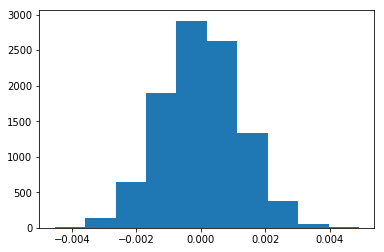

In [217]:
plt.hist(p_diffs);

**What proportion of the p_diffs are greater than the actual difference observed in ab_data.csv?**

-0.00147959979408


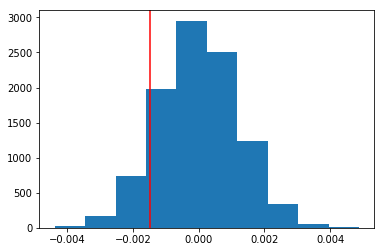

In [218]:
# actual difference in ab_data between old and new page is :
new_page = df[df['group'] == "treatment"].converted.mean()
old_page = df[df['group'] == "control"].converted.mean()
actual_diff = new_page - old_page
print(actual_diff)
# Simulating a normal distribution with mean 0 and std. of p_diffs
normal_dist = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(normal_dist)
plt.axvline(actual_diff, color = 'r')

In [219]:
# Proportion greater than the actual difference observed in ab_data.csv is : 

(p_diffs > actual_diff).mean()

0.8891

**Please explain using the vocabulary you've learned in this course what you just computed in part j.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?**

We found **p-value** in **part j**. 

In hypothesis testing, the p-value is the probability of obtaining test results at least as extreme as the results actually observed during the test, assuming that the null hypothesis is correct.

p-value is compared with the alpha (threshold for the percent of type 1 errors).

if the p value is greater than the threshold alpha, it means we failed to reject the null hypothesis.

**In our, p-value is 0.89 which is greater than 0.05, therefore, we failed to reject the null hypothesis which means conversion rate of new pages is less than the conversion rate of old pages. It also means old pages did better than the new pages.**

**We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.**

In [220]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = len(df2.query('group == "control"'))
n_new = len(df2.query('group == "treatment"'))

**Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.**

In [221]:
# Using alternative smaller because smaller means p1 < p2 where p1 is the proportion of the first sample and p2 of the second one
# Here p1 is old and p2 is new page and smaller because our alternate hypothesis is new page is better than the old page.
stats, pvalue = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
(stats, pvalue)

(1.3109241984234394, 0.90505831275902449)

**What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts j. and k.?**

**Here stats is the Z- stats and pvalue is the p-value from the z-test.**

[Z Test](https://www.investopedia.com/terms/z/z-test.asp)

>- Z-Test assumes the distribution to be normal. The z-score  is a number representing how many standard deviations above or below the mean population a score derived from a z-test is.
- If the value of z is greater than 1.96 or less than -1.96, the null hypothesis is rejected.

**The z-score we get here is 1.3109 which is less than 1.95 and p-value we get here is 0.9050 which is closer to the p-value we found 0.899 in part j and greater than 0.05. So, these values do agree to j. and k. This means, we fail to reject the null hypothesis, so the old pages perform better than new pages.**

<a id='regression'></a>
### A Regression approach

In this final part, we will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

Since each row is either a conversion or no conversion, what type of regression should we be performing in this case?

**This case is of binary outcomes, a logistic regression should be performed.**

The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [222]:
df2['intercept'] = 1
df2[['new_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2['ab_page'] = (pd.get_dummies(df2['group'])).treatment
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


**Use statsmodels to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part b. to predict whether or not an individual converts.** 

In [223]:
logit_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**Provide the summary of your model below, and use it as necessary to answer the following questions.**

In [224]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-21 16:18 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**What is the p-value associated with ab_page? Why does it differ from the value you found in Part II?<br><br> Hint: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in Part II?**

**p-value here is 0.1899.**
This p-value is the result from the two sided test and we performed one sided test in part 2. 

The null hypothesis in part 2 was the conversion rate of new page is lower than the conversion rate of old page and alternate hypothesis was conversion rate of new page is higher than conversion rate of older page.

In part 3, the hypothesis are different. Here the conversion rate is dependent on the ab_page. ab_page contains data whether the group is treatment or control which also means the page was new page or old page.

**Here,**
>- H0 (null hypothesis ) : There is no relationship between the two variables
- H1 (alternative hypothesis): There exist a relationship between the two variables.
- The smaller the p-value means the more confident you are about the existence of relationship between the two variables.

**In our case, p-value is greater therefore, there is no significant relationship between the converted and ab_page. This means the conversion of page is not much dependent on the ab_page or the groups.** 

**Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?**

Since, conversion of the page didn't depend on the ab_page, we have to consider other factors and variables in our regression model.

Factors to be considered in our regression model should be : **timestamp.**
The day of the week, time, gender, income, environment (if this data would be available) may affect the conversion rate.

The conversion rate depending on the group and landing page didn't work well because, there may be change aversion or novelty effect taking place among the people.

>- **Change Aversion** : Change aversion is the negative short-term reaction to changes in a product or service.
- **Novelty effect** : The novelty effect, in the context of human performance, is the tendency for performance to initially improve when new technology is instituted, not because of any actual improvement in learning or achievement, but in response to increased interest in the new technology.

**Disadvantages of adding additional terms is:**
>- Multicollinearity (Could be solved using VIF)
- Increased complexity



**Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the countries.csv dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables.** 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [225]:
df_countries = pd.read_csv("countries.csv")
print(df_countries.country.unique())
print(df_countries.info())
df_countries.head()


['UK' 'US' 'CA']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB
None


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [226]:
df_new = df2.merge(df_countries, on = "user_id", how = "left")

df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,0,1


In [227]:
logit_model2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page','CA', 'UK']])
results2 = logit_model2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-21 16:24 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

**Based on these results, we can see that the p-values for the country terms are definietly not significant.**

**Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.**

Provide the summary results, and your conclusions based on the results.

In [228]:
df_new['CA_ab_page'] = df_new['CA'] * df_new['ab_page']
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,CA,UK,US,CA_ab_page,UK_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,0,1,0,0


In [229]:
logit_model3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page','CA', 'UK', 'CA_ab_page', 'UK_ab_page']])
results3 = logit_model3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-21 16:24 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

**Based on these results, still there are no significant terms including interaction terms. Also, interaction terms made the original country terms significance much worse. Therefore, we should not include these interaction terms.**

### Conclusion

>According, to analysis using **Probability, hypothesis testing and regression model**, we have enough evidence that company should keep the old page and not to implement the new page as we have failed to reject our null hypothesis in every statistics which is old page performed better than new page.

In [231]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0